In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os

from tensorflow import keras
from matplotlib.lines import Line2D
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, balanced_accuracy_score
from functools import reduce

In [5]:
def gen_data_set(attribute_df, data_df, range_date:int, shuffledata=True):
    feature_1_list = []
    feature_2_list = []
    id_list = []
    invalid_id = []

    for id, frame in data_df.groupby('unique_id'):
        if len(frame) == range_date:
            feature_2_list.append(frame['feature_2'].values)
            feature_1_list.append(frame['feature_1'].values)
            id_list.append(id)
        else:
            invalid_id.append(id)
            continue

    feature_2_list = np.array(feature_2_list)
    feature_1_list = np.array(feature_1_list)
    id_list = np.array(id_list)
    data_set = np.dstack((feature_1_list, feature_2_list))

    attribute_df_data_set = pd.DataFrame({'unique_id':id_list}).astype({'unique_id':'string'}).merge(attribute_df, on='unique_id', how='left', indicator=True)
    mask_data = attribute_df_data_set['_merge'] == 'both'
    data_set = data_set[mask_data]
    attribute_df_data_set = attribute_df_data_set[mask_data]


    data_set_y = attribute_df_data_set['y_true'].values.astype(np.float32)

    print('valid data count : %d' % len(id_list))
    print('invalid data count : %d' % len(invalid_id))
    print('total data count: %d' % len(data_set_y))

    if shuffledata:
        data_set, data_set_y = shuffle(data_set, data_set_y)

    return data_set, data_set_y

In [6]:
def add_jitter(data, scale=0.1):
    return data + np.random.normal(scale=scale, size=len(data))

In [250]:
def gen_augmentation_data(id_extent, number_gen, feature_1_df, feature_2_df):
    feature_1 = feature_1_df.merge(id_extent, on='unique_id')
    feature_2 = feature_2_df.merge(id_extent, on='unique_id')
    train_df = pd.merge(feature_2, feature_1,  how='left', left_on=['unique_id','dateTime'], right_on = ['unique_id','dateTime'])

    feature_2_list = []
    feature_1_list = []
    id_list = []
    invalid_id = []

    for id, frame in train_df.groupby('unique_id'):
        if len(frame) == 30:
            feature_2_list.append(frame['feature_2'].values)
            feature_1_list.append(frame['feature_1'].values)
            id_list.append(id)
        else:
            invalid_id.append(id)
            continue

    feature_2_list = np.array(feature_2_list)
    feature_1_list = np.array(feature_1_list)

    data_set_extent = np.dstack((feature_1_list, feature_2_list))
    
    feature_1_extent_list = []
    feature_2_extent_list = []
    
    for i in range(number_gen):
        data = data_set_extent[np.random.randint(len(data_set_extent))]
        feature_1_extent_list.append(add_jitter(data[:, 0], scale=0.025))
        feature_2_extent_list.append(add_jitter(data[:, 1], scale=0.0125))
            
    data_set_extent = np.dstack((feature_1_extent_list, feature_2_extent_list))
    return data_set_extent

In [ ]:
my_bucket = '/path/to/data'
data_lst = ['province1_2019', 'province1_2020', 'province1_2021', 'province2_2019', 'province2_2020', 'province2_2021']

feature_1_df_period_lst = []
feature_2_df_period_lst = []
attribute_df_lst = []

for data_set in data_lst:
    my_file = 'attribute_df/%s.parquet.gzip' % data_set
    data_path = '%s/%s' % (my_bucket, my_file)


    transform_numeric_class_dict = {'class_0': 0,
                                    'class_1' : 1,
                                    'class_2' : 1}
    
    attribute_df = pd.read_parquet(data_path)
    attribute_df['y_true'].replace(transform_numeric_class_dict, inplace=True)
    attribute_df['y_true'] = attribute_df['y_true'].fillna(0)

    attribute_df = attribute_df.astype({'unique_id':'string'})
    attribute_df_lst.append(attribute_df)

    feature_1_df_period = pd.read_parquet('%s/period_data/%s' % (my_bucket, 'feature_1_%s_period_model.parquet.gzip' % data_set))
    feature_2_df_period = pd.read_parquet('%s/period_data/%s' % (my_bucket, 'feature_2_%s_period_model.parquet.gzip' % data_set))
    
    feature_1_df_period_lst.append(feature_1_df_period)
    feature_2_df_period_lst.append(feature_2_df_period)
    

if len(attribute_df_lst) > 1 :
    print('multiple dataset')
    attribute_df = pd.concat(attribute_df_lst)
    feature_1_df = pd.concat(feature_1_df_period_lst, axis=0)
    feature_2_df = pd.concat(feature_2_df_period_lst, axis=0)
    

del attribute_df_lst
del feature_1_df_period_lst
del feature_2_df_period_lst

attribute_df['y_true'].value_counts()

In [34]:
# select sample 600 data for each 'province' or 0.3*len data province
sample1 = attribute_df[np.logical_and(attribute_df['y_true'] == 1, attribute_df['province'] == 30)].sample(600)
sample2 = attribute_df[np.logical_and(attribute_df['y_true'] == 1, attribute_df['province'] == 64)].sample(round(457*0.3))
sample3 = attribute_df[np.logical_and(attribute_df['y_true'] == 1, attribute_df['province'] == 45)].sample(round(71*0.3))

class1_id = pd.concat([sample1, sample2, sample3])['unique_id']

In [102]:
n_samp = 1800

class0_id = attribute_df[(attribute_df['y_true'].values == 0)].groupby(['project_year', 'province']).sample(n=n_samp//9)['unique_id']


In [103]:
train_id = pd.concat([class0_id, class1_id], axis=0)

In [104]:
train_df = pd.merge(feature_2_df, feature_1_df,  how='left', left_on=['unique_id','dateTime'], right_on = ['unique_id', 'dateTime'])
train_df = train_df[train_df['unique_id'].isin(train_id)]

In [ ]:
data_set, data_set_y = gen_data_set(attribute_df, train_df, 30, shuffledata=True)

Augmentation for handle imbalance data

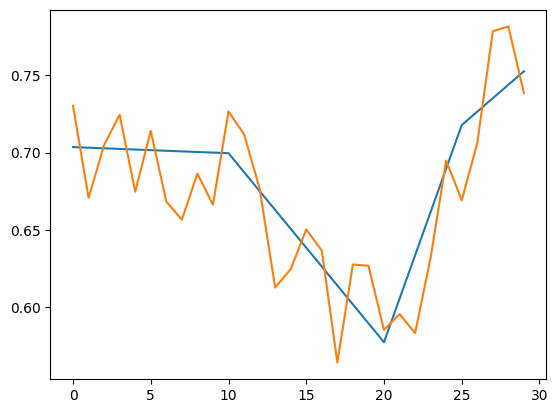

In [33]:
# plot example feature_1 data augmentationm
plt.plot(data_set[17][:, 0])
plt.plot(add_jitter(data_set[17][:, 0], scale=0.025))
plt.show()

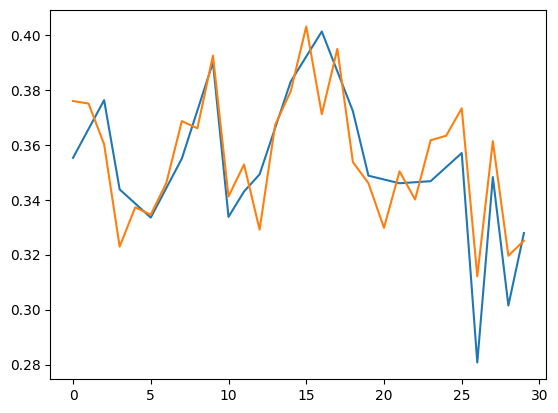

In [34]:
# plot example feature_2 data augmentationm
plt.plot(data_set[17][:, 1])
plt.plot(add_jitter(data_set[17][:, 1], scale=0.0125))
plt.show()

In [255]:
sample2_data_extent = gen_augmentation_data(sample2['unique_id'], 600 - len(sample2['unique_id']), feature_1_df, feature_2_df)
sample3_data_extent = gen_augmentation_data(sample3['unique_id'], 600 - len(sample3['unique_id']), feature_1_df, feature_2_df)

In [258]:
all_data_set_extent = np.concatenate((sample2_data_extent, sample3_data_extent), axis=0)

In [259]:
data_set = np.concatenate((data_set, all_data_set_extent), axis=0)
data_set_y = np.concatenate((data_set_y, np.full(len(all_data_set_extent), 1.0)), axis=0)

In [265]:
data_set.shape

(3596, 30, 2)

In [268]:
data_set_y.shape

(3596,)

Training Data

In [269]:
data_set, data_set_y = shuffle(data_set, data_set_y)

In [270]:
idx_split = round(len(data_set)*0.7)

x_train = data_set[:idx_split]
x_test = data_set[idx_split:]

y_train = data_set_y[:idx_split]
y_test = data_set_y[idx_split:]

In [271]:
num_classes = len(np.unique(data_set_y))

In [272]:
attribute_df_train['y_true'].value_counts()

0    1796
1     758
Name: loss_type, dtype: int64

In [273]:
x_train.shape

(2517, 30, 2)

In [274]:
pd.DataFrame(y_train).value_counts()

0.0    1300
1.0    1217
dtype: int64

LSTM-FCN binary classification model 

In [277]:
def lstm_fcn(input_shape):
    # F. Karim, S. Majumdar, H. Darabi, and S. Chen, “LSTM Fully Convolutional Networks for Time Series Classification,” IEEE Access, vol. 6, pp. 1662–1669, 2018.

    ip = keras.layers.Input(shape=input_shape)
    
    lstm = keras.layers.Permute((2, 1))(ip)

    lstm = keras.layers.LSTM(128)(lstm)
    lstm = keras.layers.Dropout(0.8)(lstm)

    conv = keras.layers.Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation('relu')(conv)

    conv = keras.layers.Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation('relu')(conv)

    conv = keras.layers.Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation('relu')(conv)

    flat = keras.layers.GlobalAveragePooling1D()(conv)

    flat = keras.layers.concatenate([lstm, flat])

    out = keras.layers.Dense(1, activation='sigmoid')(flat)

    model = keras.models.Model([ip], [out])

    model.summary()

    return model


In [278]:
model = lstm_fcn(input_shape=x_train.shape[1:], nb_class=num_classes)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 2)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 30, 128)      2176        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 30, 128)     512         ['conv1d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 30, 128)      0           ['batch_normalization_6[0][

In [279]:
epochs = 150
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        '/path/to/checkpoint/best_model_%s.h5' % 'mix', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1),
]
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/150
63/63 [==============================] - 3s 15ms/step - loss: 0.5419 - accuracy: 0.7377 - val_loss: 0.6883 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 2/150
63/63 [==============================] - 1s 8ms/step - loss: 0.4926 - accuracy: 0.7675 - val_loss: 1.2220 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 3/150
63/63 [==============================] - 1s 9ms/step - loss: 0.4509 - accuracy: 0.7928 - val_loss: 1.8270 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 4/150
63/63 [==============================] - 1s 12ms/step - loss: 0.3868 - accuracy: 0.8162 - val_loss: 1.8068 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 5/150
63/63 [==============================] - 1s 11ms/step - loss: 0.3622 - accuracy: 0.8395 - val_loss: 1.3186 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 6/150
63/63 [==============================] - 1s 13ms/step - loss: 0.3271 - accuracy: 0.8639 - val_loss: 0.6346 - val_accuracy: 0.7202 - lr: 0.0010
Epoch 7/150
63/63 [==============================] - 1s 13ms/step - loss

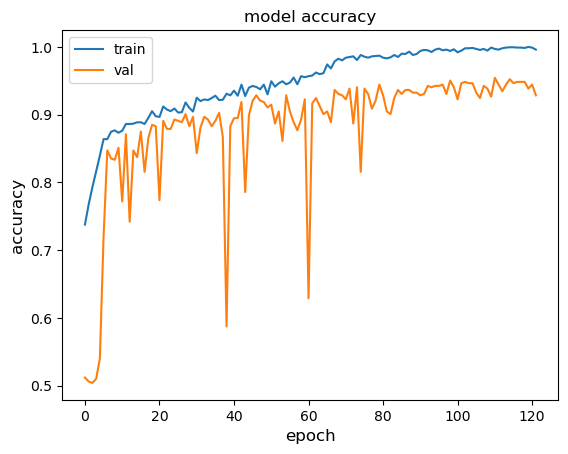

In [280]:
metric = 'accuracy'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.close()

In [281]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'sparse_categorical_accuracy'],
)

test_loss, test_acc, test_pre, test_recl, test_scc = model.evaluate(x_test, y_test)

print('Test accuracy', test_acc)
print('Test loss', test_loss)


34/34 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.9045 - precision_4: 0.9461 - recall_4: 0.8731 - sparse_categorical_accuracy: 0.4597
Test accuracy 0.9045412540435791
Test loss 0.3676486909389496


In [282]:
y_preds = model.predict(x_test)

34/34 [==============================] - 0s 4ms/step


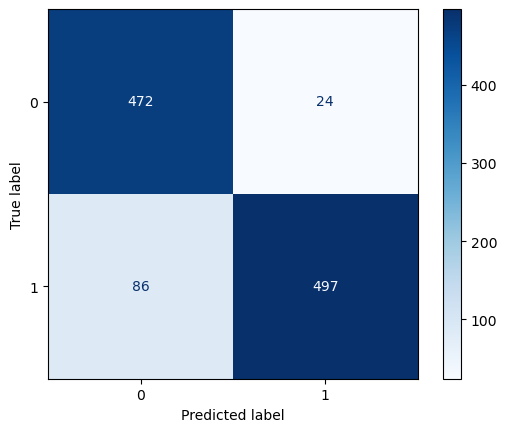

In [283]:
cm = confusion_matrix(y_test, np.where(y_preds > 0.7, 1,0))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.show()


In [324]:
model.save('/path/to/model/lstm_model/lstm_%s_v1.h5' % 'kr-skt-rit')

Test All Data

In [284]:
def evaluate_model(df, y_preds_col, class_thred):

    y_true = df['y_true'].astype(int)
    y_scores = (df[y_preds_col] > class_thred).astype(int)

    print('accuracy score : %f' % accuracy_score(y_true, y_scores))
    print('balanced accuracy score : %f' % balanced_accuracy_score(y_true, y_scores))

    df_fp = df[np.logical_and(y_scores == 1 , y_true == 0)]
    df_fn = df[np.logical_and(y_scores == 0 , y_true == 1)]
    df_tp = df[np.logical_and(y_scores == 1 , y_true == 1)]
    df_tn = df[np.logical_and(y_scores == 0 , y_true == 0)]

    print('False Negative rate : %f' % (len(df_fn) / (len(df_tp) + len(df_fn))))
    print('False Positive rate : %f' % (len(df_fp) / (len(df_tn) + len(df_fp))))

    cm = confusion_matrix(y_true, y_scores)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    
    print('False Positive : %d' % len(df_fp))
    print('False Negative : %d' % len(df_fn))
    print('True Positive : %d' % len(df_tp))
    print('True Negative: %d' % len(df_tn))

    return df_fp, df_fn, df_tp, df_tn


In [285]:
def transpose_df(df, band):
    data_period = []
    for id,frame in df.groupby('unique_id'):
        if len(frame) > 366:
            continue
        data = pd.DataFrame(frame[band].values).T
        data['unique_id'] = id
        data_period.append(data)

    return pd.concat(data_period, ignore_index=True, axis=0)

In [286]:
# model = keras.models.load_model('/path/to/model/lstm_model/.h5')

In [287]:
test_id = attribute_df[np.logical_or(attribute_df['y_true'] == 0, attribute_df['y_true'] == 1)]['unique_id']
print('test data total %d' % len(test_id))

test data total 740033


In [288]:
intersect_test_id = reduce(np.intersect1d, (test_id.values, feature_2_df['unique_id'].unique(), feature_1_df['unique_id'].unique()))

In [289]:
len(intersect_test_id)

739815

In [290]:
feature_1_df_test = feature_1_df[feature_1_df['unique_id'].isin(intersect_test_id)]
feature_2_df_test = feature_2_df[feature_2_df['unique_id'].isin(intersect_test_id)]

In [292]:
test_df = pd.merge(feature_2_df_test, feature_1_df_test,  how='left', left_on=['unique_id','dateTime'], right_on = ['unique_id','dateTime'])

In [ ]:
data_set_test, data_set_test_y = gen_data_set(attribute_df, test_df, 30, shuffledata=True)

In [297]:
model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'sparse_categorical_accuracy'],
)

test_loss, test_acc, test_pres, test_rec, test_sca = model.evaluate(data_set_test, data_set_test_y.astype(np.float32))

print('Test accuracy', test_acc)
print('Test loss', test_loss)
print('Test Precision', test_pres)
print('Test Recall', test_rec)
print('Test Sparse categorical accuracy', test_sca)


23102/23102 [==============================] - 121s 5ms/step - loss: 0.1441 - accuracy: 0.9610 - precision_5: 0.6641 - recall_5: 0.7773 - sparse_categorical_accuracy: 0.9367
Test accuracy 0.9610112905502319
Test loss 0.14409379661083221
Test Precision 0.6640984416007996
Test Recall 0.7772554159164429
Test Sparse categorical accuracy 0.9366944432258606


In [298]:
y_preds = model.predict(data_set_test)
attribute_df['y_preds'] = y_preds

23102/23102 [==============================] - 156s 7ms/step


accuracy score : 0.964056
balanced accuracy score : 0.857343
False Negative rate : 0.264840
False Positive rate : 0.020474


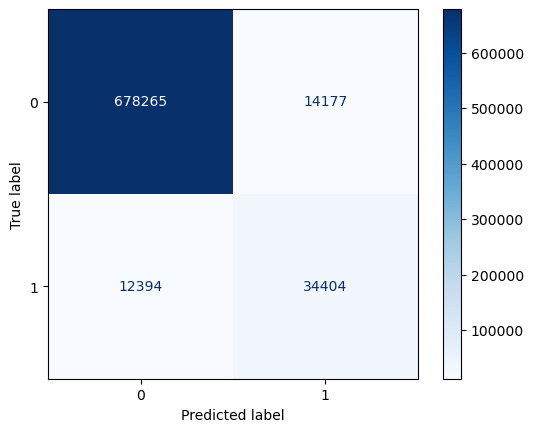

fp : 14177
fn : 12394
tp : 34404
tn : 678265


In [328]:
attribute_fp, attribute_fn, attribute_tp, attribute_tn = evaluate_model(attribute_df, 'y_preds', 0.7)

In [299]:
attribute_df['province'].value_counts()

45    350895
30    332712
64     55633
Name: province, dtype: int64

accuracy score : 0.974350
balanced accuracy score : 0.791763
False Negative rate : 0.393873
False Positive rate : 0.022600


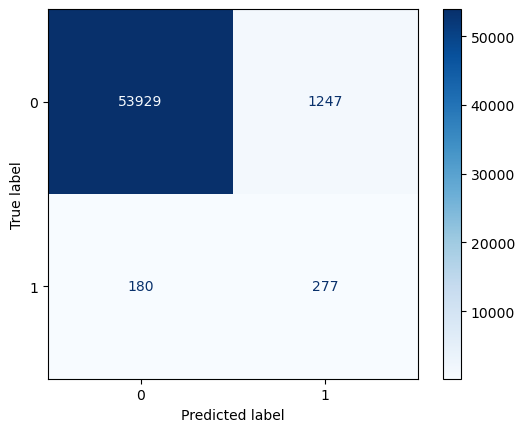

fp : 1247
fn : 180
tp : 277
tn : 53929


In [334]:
attribute_fp, attribute_fn, attribute_tp, attribute_tn = evaluate_model(attribute_df[attribute_df['province'] == 64], 'y_preds', 0.7)

30

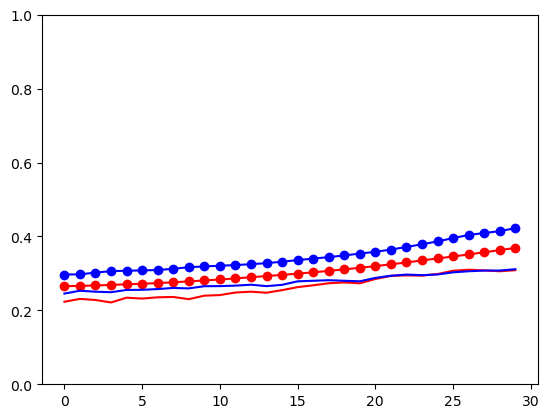

In [306]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

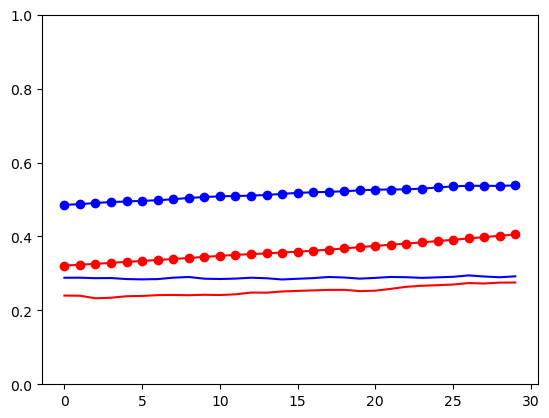

In [307]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fn['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')

64

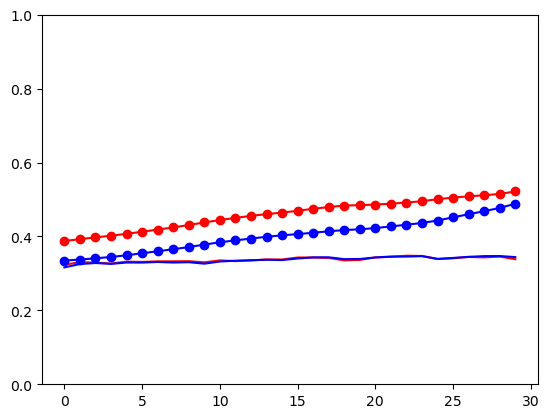

In [309]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

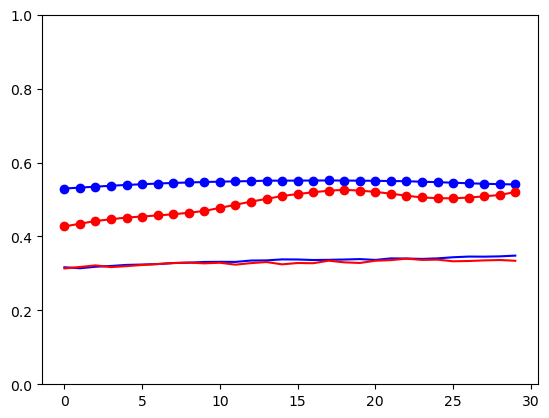

In [310]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fn['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')

45

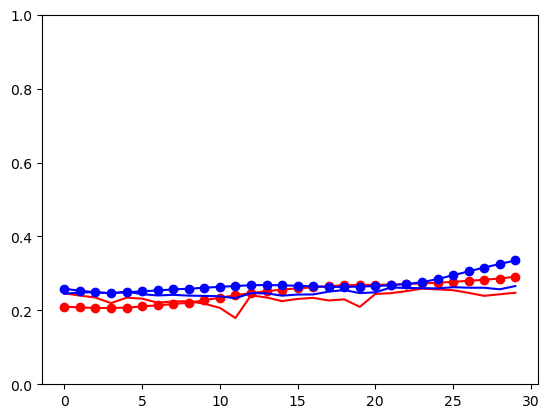

In [312]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fp['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

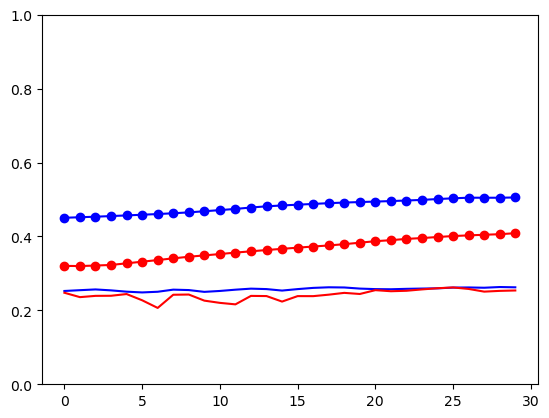

In [313]:
transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_tn['unique_id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.figure()
plt.ylim((0, 1))

plt.plot(feature_1_avg, 'b-o')
plt.plot(feature_2_avg, 'b')

transpose_feature_2 = transpose_df(feature_2_df.merge(attribute_fn['unique_id'], on='unique_id'), 'feature_2')
transpose_feature_1 = transpose_df(feature_1_df.merge(attribute_fn['reference _id'], on='unique_id'), 'feature_1')

feature_1_avg = transpose_feature_1.drop(columns='unique_id').mean(axis=0).values
feature_2_avg = transpose_feature_2.drop(columns='unique_id').mean(axis=0).values

plt.plot(feature_1_avg, 'r-o')
plt.plot(feature_2_avg, 'r')